Checking required packages...
Please select the data folder window...
Selected Directory: D:/python_workplace/ESP32_autonomous_driving/20251224_21_30_41
Original data count: 2161
Filtered data count (removed backward): 2160
Loading images and syncing labels...


100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:06<00:00, 310.00it/s]


Final loaded tensors shape: (2160, 120, 160, 3)
Final loaded targets shape: (2160,)


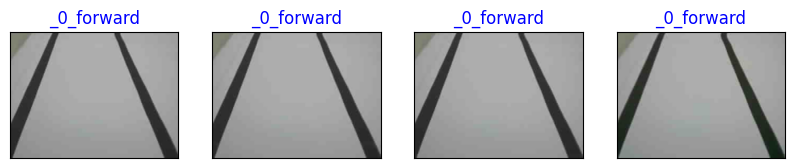

Train shapes: (1728, 120, 160, 3), (1728, 4)
Test shapes: (216, 120, 160, 3), (216, 4)
Valid shapes: (216, 120, 160, 3), (216, 4)
Starting training...
Epoch 1/100
54/54 [==============================] - 1s 7ms/step - loss: 1.0684 - accuracy: 0.5747 - val_loss: 1.0048 - val_accuracy: 0.5787
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 1.0094 - accuracy: 0.5891 - val_loss: 0.9790 - val_accuracy: 0.5787
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.9100 - accuracy: 0.6134 - val_loss: 0.7291 - val_accuracy: 0.7083
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7629 - accuracy: 0.7066 - val_loss: 0.6172 - val_accuracy: 0.7731
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.6062 - accuracy: 0.7668 - val_loss: 0.5770 - val_accuracy: 0.7731
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.5239 - accuracy: 0.8027 - val_loss: 0.4853 - val_accuracy: 0.8148
Epo

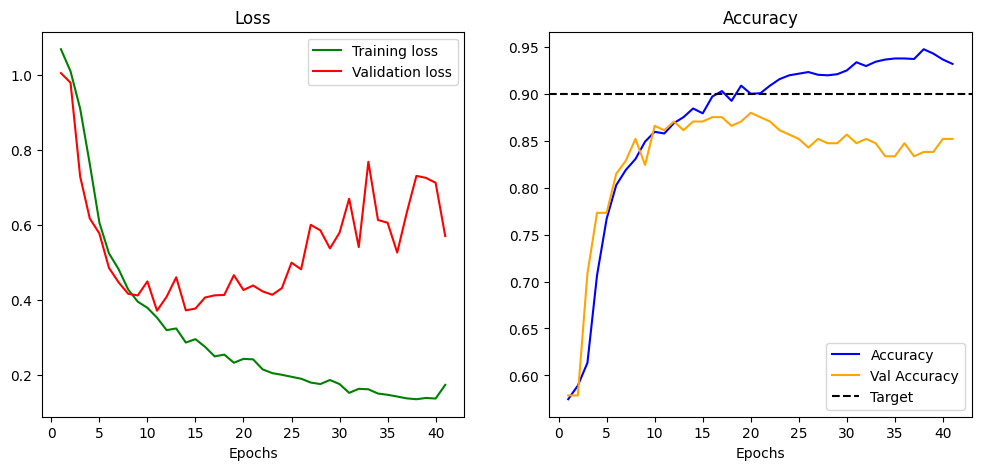

Model saved to model_CNN_20251225180145.h5
Evaluating model...
Loaded generated model: model_CNN_20251225180145.h5
7/7 [==============================] - 0s 3ms/step


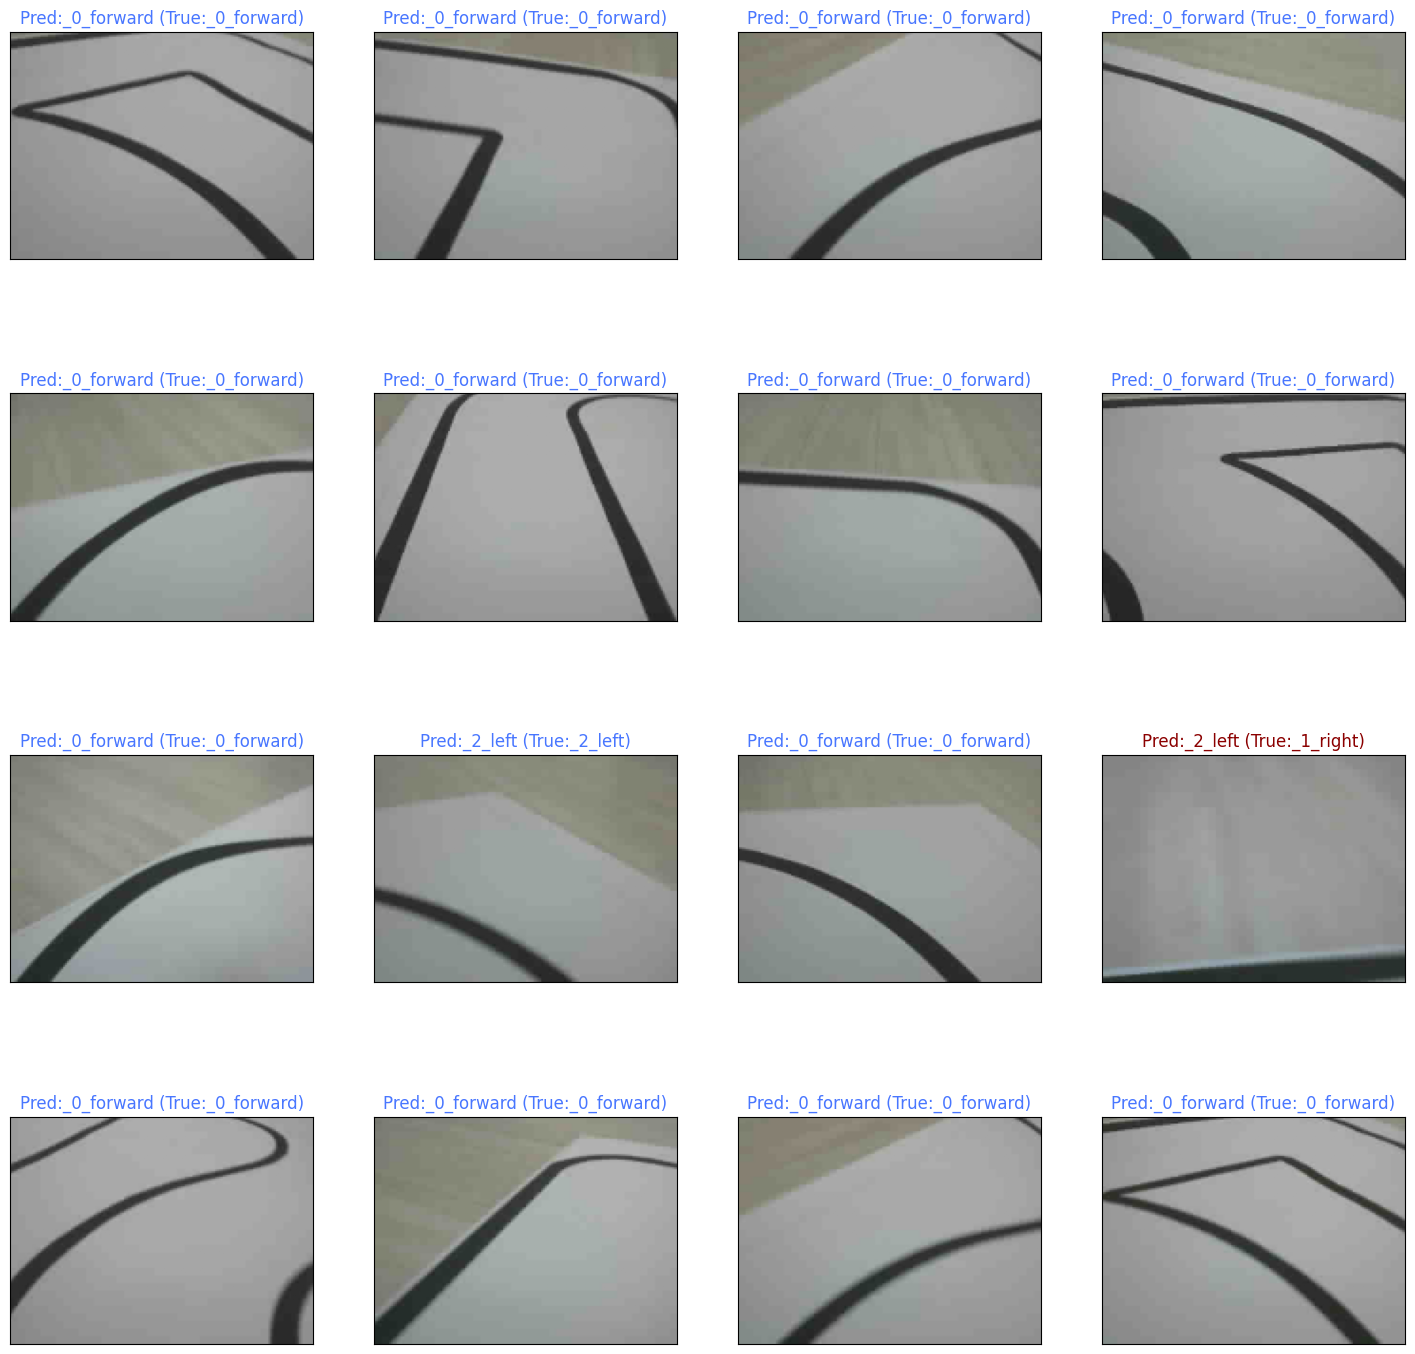

In [5]:
import sys
import subprocess
import importlib
import os
import tkinter as tk
from tkinter import filedialog
from datetime import datetime

# ---------------------------------------------------------
# 1. 패키지 자동 설치 함수
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")
            sys.exit(1)

# 필수 패키지 확인 및 설치
print("Checking required packages...")
install_package("tensorflow")
install_package("numpy")
install_package("pandas")
install_package("tqdm")
install_package("PIL", "Pillow")
install_package("cv2", "opencv-python")
install_package("matplotlib")
install_package("sklearn", "scikit-learn")

# ---------------------------------------------------------
# 2. 라이브러리 임포트
# ---------------------------------------------------------
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------
# 3. 데이터 로드 및 전처리
# ---------------------------------------------------------

print("Please select the data folder window...")
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()
root.focus_force()
dirname = filedialog.askdirectory(title='Select Data Folder to Train')
root.destroy()

if not dirname:
    print("No folder selected. Exiting...")
    sys.exit()

print(f"Selected Directory: {dirname}")

if not dirname.endswith('/'):
    dirname += '/'

def image_to_tensor(img_path):
    try:
        path = os.path.join(dirname, img_path)
        if not os.path.exists(path):
            print(f"File missing: {img_path}")
            return None
            
        img = keras_image.load_img(path, target_size=(120,160))
        x = keras_image.img_to_array(img)
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

ImageFile.LOAD_TRUNCATED_IMAGES = True

csv_path = os.path.join(dirname, "0_road_labels.csv")
if not os.path.exists(csv_path):
    print(f"Error: CSV file '{csv_path}' not found in the selected folder.")
    sys.exit()

data = pd.read_csv(csv_path)

print(f"Original data count: {len(data)}")
data = data[data['label'] != 4]
print(f"Filtered data count (removed backward): {len(data)}")

data = data.reset_index(drop=True)

print("Loading images and syncing labels...")

valid_tensors = []
valid_labels = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = row['file']
    label = row['label']
    
    tensor = image_to_tensor(img_path)
    
    if tensor is not None:
        valid_tensors.append(tensor)
        valid_labels.append(label)

if len(valid_tensors) > 0:
    tensors = np.vstack(valid_tensors)
    targets = np.array(valid_labels)
else:
    print("Error: No valid images loaded.")
    sys.exit()

files = data['file'].values[:len(targets)] 

print(f"Final loaded tensors shape: {tensors.shape}")
print(f"Final loaded targets shape: {targets.shape}")

if tensors.shape[0] != targets.shape[0]:
    print("Error: Mismatch between images and labels.")
    sys.exit()
# ---------------------------------------------------------
# 4. 데이터 시각화
# ---------------------------------------------------------
names = ['_0_forward', '_1_right', '_2_left', '_3_stop']

def display_images(img_path, ax):
    img = cv2.imread(os.path.join(dirname, img_path))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
count = 0
for i in range(len(files)):
    if count >= 4: break
    ax = fig.add_subplot(1, 4, count + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i]], color='blue')
    display_images(files[i], ax)
    count += 1
plt.show()

# ---------------------------------------------------------
# 5. 데이터셋 분리
# ---------------------------------------------------------
tensors = tensors.reshape(-1,120,160,3)

tensors = tensors.astype('float32')/255

targets = to_categorical(targets, 4)

x_train, x_test, y_train, y_test = train_test_split(
        tensors,
        targets,
        test_size = 0.2,
        random_state = 1,
        stratify=targets)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(f"Train shapes: {x_train.shape}, {y_train.shape}")
print(f"Test shapes: {x_test.shape}, {y_test.shape}")
print(f"Valid shapes: {x_valid.shape}, {y_valid.shape}")

# ---------------------------------------------------------
# 6. 모델
# ---------------------------------------------------------
model = tf.keras.Sequential([ # donkey car CNN style
    tf.keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same",
        activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same",
        activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy'])

# ---------------------------------------------------------
# 7. 학습 실행
# ---------------------------------------------------------

# [설정 1] 목표 정확도 도달 시 종료
class ReachTargetAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc):
        super(ReachTargetAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n\n검증 정확도가 목표치({self.target_acc*100:.2f}%)에 도달했습니다: {val_acc*100:.4f}%")
            self.model.stop_training = True

# [설정 2] Loss가 더 이상 안 줄어들면 종료
early_stop_loss = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# [설정 3] Accuracy가 더 이상 안 오르면 종료
early_stop_acc = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# 목표 정확도 설정 (예: 90%)
TARGET_ACCURACY = 0.90
target_acc_callback = ReachTargetAccuracy(target_acc=TARGET_ACCURACY)

print("Starting training...")

callbacks_list = [early_stop_loss, early_stop_acc, target_acc_callback]

history = model.fit(
    x_train, y_train,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    epochs=100,
    callbacks=callbacks_list
)

# 학습 곡선 시각화
loss = history.history['loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'g', label='Training loss')
if 'val_loss' in history.history:
    plt.plot(epochs_range, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], 'b', label='Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs_range, history.history['val_accuracy'], 'orange', label='Val Accuracy')
    plt.axhline(y=TARGET_ACCURACY, color='k', linestyle='--', label='Target')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# ---------------------------------------------------------
# 모델 저장
# ---------------------------------------------------------
current_time = datetime.now().strftime("%Y%m%d%H%M%S")
filename = f"model_CNN_{current_time}.h5"
model.save(filename)
print(f"Model saved to {filename}")

# ---------------------------------------------------------
# 8. 테스트 및 검증
# ---------------------------------------------------------
print("Evaluating model...")

if os.path.exists(filename):
    model1 = load_model(filename)
    print(f"Loaded generated model: {filename}")
else:
    model1 = load_model('model.h5')
    print("Loaded default model: model.h5")

y_test_predict = model1.predict(x_test)
y_test_predict = np.argmax(y_test_predict,axis=1)

# 테스트 데이터 시각화
sample_size = min(16, x_test.shape[0])
if sample_size > 0:
    fig = plt.figure(figsize=(18, 18))
    indices = np.random.choice(x_test.shape[0], size=sample_size, replace=False)
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(x_test[idx]))
        pred_idx = y_test_predict[idx]
        true_idx = np.argmax(y_test[idx])
        ax.set_title("Pred:{} (True:{})".format(names[pred_idx], names[true_idx]),
            color=("#4876ff" if pred_idx == true_idx else "darkred"))
    plt.show()
else:
    print("Not enough test data to visualize.")